In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from torch.utils.data import DataLoader
from pmoe.datasets import build_vc_dataset, build_trte_dataloader, NumpyDataset
from pmoe.bayes_models import BayesLogisticRegressionSGHMC, BayesianLogisticRegressionVI
from pmoe.moe_models import MoELogisticRegression
%matplotlib inline

In [2]:
torch.manual_seed(123)

We build the degrees for the VC-dimension dataset and they will consist of `[1,2,3,4,5,6,7,8]`.  We will test this against different types of Bayesian Logistic Regressions against MoEs with `[2,3,4]` experts.

In [3]:
degrees = [i for i in range(1, 9)]
features = 2
tr_datasets = {}
te_datasets = {}
dataloaders = {}
for d in degrees:
    # Build and store the train data
    data = build_vc_dataset(lower_bound=-3., upper_bound=3., n_samples=12000, features=features, degree=d)

    # Build the data sets
    tr_data, te_data = data[:-2000], data[-2000:]
    tr_datasets[d] = tr_data
    te_datasets[d] = te_data
    tr_load, te_load = build_trte_dataloader(tr_data)
    dataloaders[d] = (tr_load, te_load)

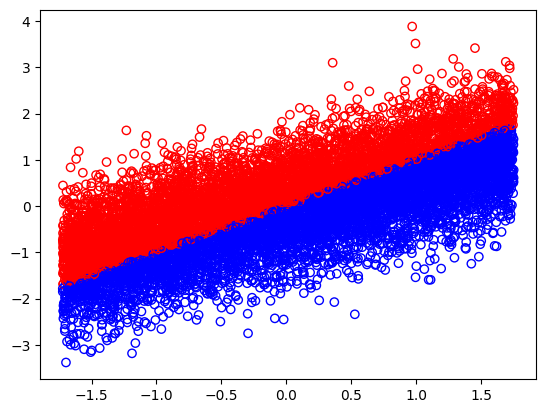

In [4]:
labels = tr_datasets[1][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[1][:,0], tr_datasets[1][:,1], facecolors='none', edgecolors=colors)

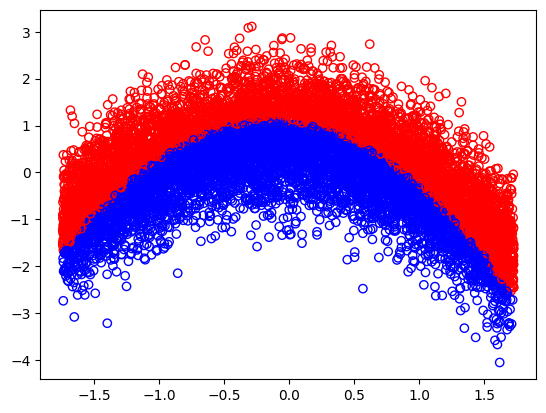

In [5]:
labels = tr_datasets[2][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[2][:,0], tr_datasets[2][:,1], facecolors='none', edgecolors=colors)

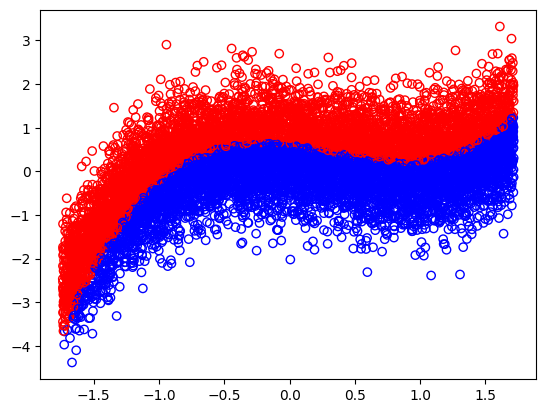

In [6]:
labels = tr_datasets[3][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[3][:,0], tr_datasets[3][:,1], facecolors='none', edgecolors=colors)

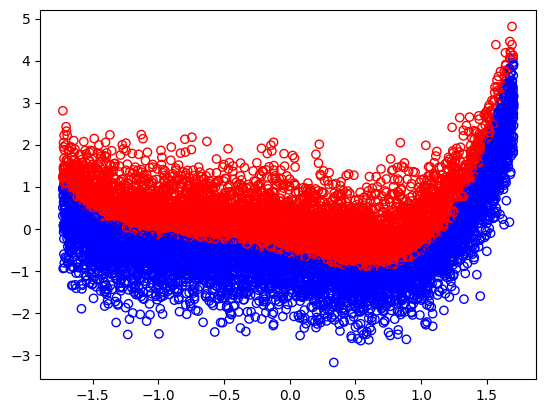

In [7]:
labels = tr_datasets[4][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[4][:,0], tr_datasets[4][:,1], facecolors='none', edgecolors=colors)

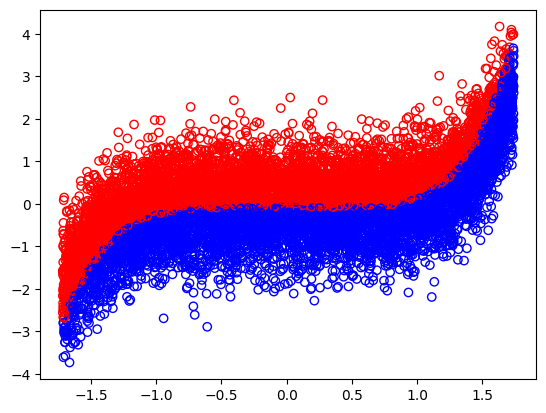

In [8]:
labels = tr_datasets[5][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[5][:,0], tr_datasets[5][:,1], facecolors='none', edgecolors=colors)

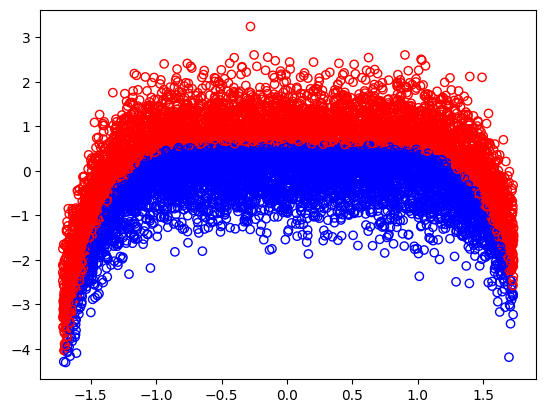

In [9]:
labels = tr_datasets[6][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[6][:,0], tr_datasets[6][:,1], facecolors='none', edgecolors=colors)

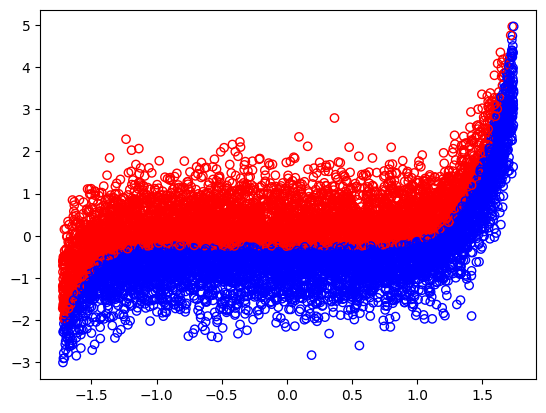

In [10]:
labels = tr_datasets[7][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[7][:,0], tr_datasets[7][:,1], facecolors='none', edgecolors=colors)

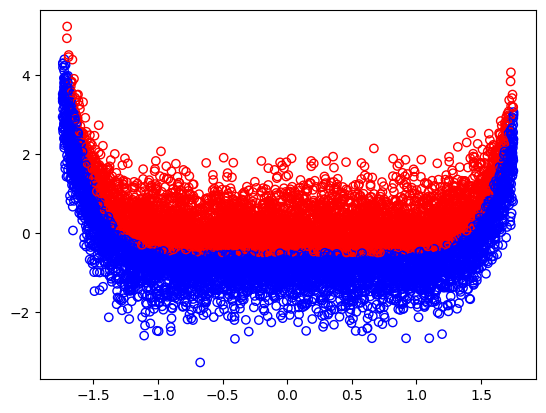

In [11]:
labels = tr_datasets[8][:,-1]
colors = ['red' if label == 1.0 else 'blue' for label in labels]
plt.scatter(tr_datasets[8][:,0], tr_datasets[8][:,1], facecolors='none', edgecolors=colors)

In [12]:
max_experts = 4
moe_models = [i for i in range(2, max_experts+1)]

In [13]:
# Saving the results
sghmc_loss = []
sghmc_acc = []
vi_loss = []
vi_acc = []
expert_loss = np.zeros((len(degrees), len(moe_models)))
expert_acc = np.zeros((len(degrees), len(moe_models)))

# Parameters for the MoE as degrees increase
EPOCHS = [25*d if d <= 6 else 150 for d in degrees]
for i, d in enumerate(degrees):
    # Get the loaders
    tr_load, val_load = dataloaders[d]

    # Get the test set and build dataloader
    test_set = te_datasets[d]
    test_set = NumpyDataset(X=test_set[:,:-1], Y=test_set[:,-1])
    te_load = DataLoader(test_set, batch_size=64, shuffle=True)

    # Train the SGHMC model
    print(f'Training SGHMC for degree {d}.')
    model_sghmc = BayesLogisticRegressionSGHMC(in_features=features+1)
    model_sghmc.fit(tr_loader=tr_load, te_loader=val_load, k=2, epochs=100, epoch_to_save=84)

    # Evaluate the model
    te_loss, te_acc = model_sghmc.evaluate(te_loader=te_load, ensemble=True)
    sghmc_loss.append(te_loss)
    sghmc_acc.append(te_acc)

    # Train the VI model
    print(f'Training VI for degree {d}.')
    model_vi = BayesianLogisticRegressionVI(in_features=features+1)
    model_vi.fit(tr_loader=tr_load, te_loader=val_load, epochs=100, lr=0.01, t=0.1, n_samples=16)

    # Evaluate the model
    te_loss, te_acc = model_vi.evaluate(te_loader=te_load, n_samples=16)
    vi_loss.append(te_loss)
    vi_acc.append(te_acc)

    # Run the MoE Models
    for j, experts in enumerate(moe_models):
        # Train the MoE
        print(f'Training MoE with {experts} experts for degree {d}.')
        model_moe = MoELogisticRegression(n_experts=experts, in_features=features+1)
        model_moe.fit(tr_loader=tr_load, te_loader=val_load, epochs=EPOCHS[i], lr=0.001)

        # Evaluate the model
        te_loss, te_acc = model_moe.evaluate(te_loader=te_load)
        expert_loss[i,j] = te_loss
        expert_acc[i,j] = te_acc

Training SGHMC for degree 1.
Using device: mps
Metrics for epoch 0 are:
 tr_loss: 0.0228588265478611, te_loss: 1.3115110211074352, te_acc: 0.384765625
Metrics for epoch 5 are:
 tr_loss: 0.015205489568412304, te_loss: 0.9286660216748714, te_acc: 0.42236328125
Metrics for epoch 10 are:
 tr_loss: 0.013222681671380996, te_loss: 0.815387511625886, te_acc: 0.4609375
Metrics for epoch 15 are:
 tr_loss: 0.012256001733243465, te_loss: 0.7589458208531141, te_acc: 0.4853515625
Metrics for epoch 20 are:
 tr_loss: 0.011663572795689105, te_loss: 0.7215613108128309, te_acc: 0.49560546875
Metrics for epoch 25 are:
 tr_loss: 0.011254754401743412, te_loss: 0.6956528220325708, te_acc: 0.5
Metrics for epoch 30 are:
 tr_loss: 0.010950755156576633, te_loss: 0.6760293021798134, te_acc: 0.50048828125
Metrics for epoch 35 are:
 tr_loss: 0.010713276587426662, te_loss: 0.6630036570131779, te_acc: 0.513671875
Metrics for epoch 40 are:
 tr_loss: 0.010520964421331883, te_loss: 0.6493062507361174, te_acc: 0.5546875


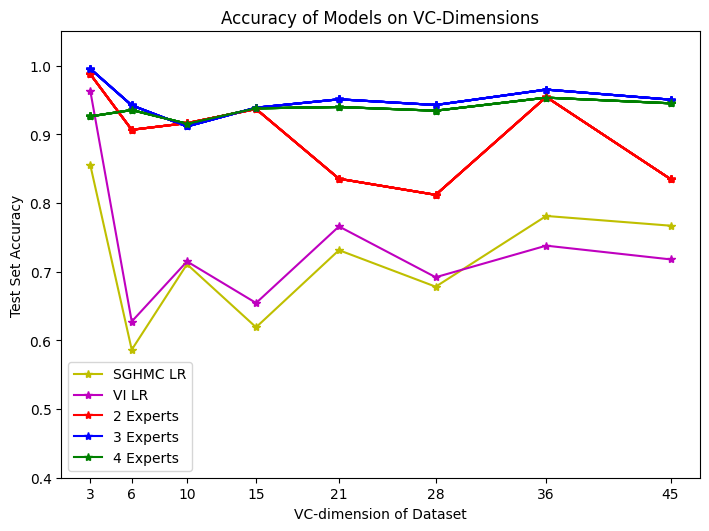

In [14]:
fig, axs = plt.subplots(1,1, figsize=(7,5))
colors = ['r*-', 'b*-', 'g*-']
vc_deg = [comb(d+2,2) for d in degrees]

# Plot the SGHMC logistic regression
axs.plot(vc_deg, sghmc_acc, 'y*-')

# Plot the VI logistic regression
axs.plot(vc_deg, vi_acc, 'm*-')

# Graph the MoE Results
for i, d in enumerate(degrees):
    for j in range(len(moe_models)):
        y = expert_acc[:,j]
        axs.plot(vc_deg, y, colors[j])

fig.tight_layout()
axs.set_xticks(vc_deg)
axs.set_xlabel('VC-dimension of Dataset')
axs.set_ylabel('Test Set Accuracy')
axs.set_ylim(0.4, 1.05)
axs.set_title('Accuracy of Models on VC-Dimensions')
axs.legend(['SGHMC LR', 'VI LR', '2 Experts', '3 Experts', '4 Experts'])
plt.show()

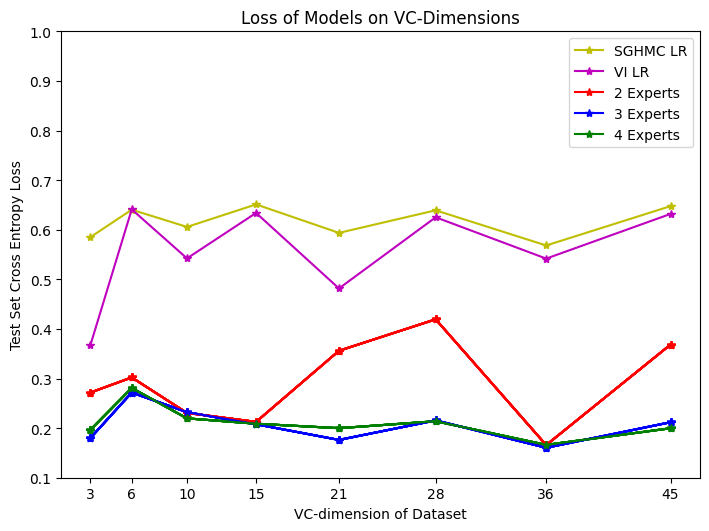

In [15]:
fig, axs = plt.subplots(1,1, figsize=(7,5))

# Plot the SGHMC logistic regression
axs.plot(vc_deg, sghmc_loss, 'y*-')

# Plot the VI logistic regression
axs.plot(vc_deg, vi_loss, 'm*-')

# Graph the MoE Results
for i, d in enumerate(degrees):
    for j in range(len(moe_models)):
        y = expert_loss[:,j]
        axs.plot(vc_deg, y, colors[j])

fig.tight_layout()
axs.set_xticks(vc_deg)
axs.set_xlabel('VC-dimension of Dataset')
axs.set_ylabel('Test Set Cross Entropy Loss')
axs.set_ylim(0.1, 1.0)
axs.set_title('Loss of Models on VC-Dimensions')
axs.legend(['SGHMC LR', 'VI LR', '2 Experts', '3 Experts', '4 Experts'])
plt.show()